The company wants to build a more personalized pricing policies for its customer and for this they have contacted you to build a pricing model.
Model Goal - "Build a model to predict prices for customers"
Target variable- contract_value



## Imports and data loading  

In [1]:
%run mlhelpers.py
%matplotlib inline

In [2]:
df = pd.read_csv('./data/df_train.csv')
print(df.shape)

(72867, 20)


In [3]:
df.rename(columns={'Unnamed: 0':'orig_index'},inplace=True)

## Missing values
drop columns with too low counts

In [4]:
# df_none_missing = df.copy()

In [5]:
# df_none_missing[df_none_missing.isnull()].shape
df.isnull().sum()

orig_index                     0
contract_segment               0
contract_value                 0
contract_date                  0
customer_type                  0
client_line_of_business      440
unneccesary_flag               0
contract_base                  0
Level1                         3
Level_3                        3
Level2                         3
internet_line                  0
store city                    51
code                       70373
usage of internet            370
customer Id                    0
validity_st                    0
validity_end                   0
contract_length                0
contract_age                   0
dtype: int64

## Feature columns

In [6]:
df.drop(columns=['code'],inplace=True)

In [7]:
target_col = 'contract_value'
feature_cols = list(set(df.columns)-set(['orig_index',target_col, 'validity_end','validity_st','contract_date', 'customer Id' ]))
# 

## Encoding

In [8]:
df_model = df.copy() 
encodeColums(df_model, cols_sent=feature_cols)

# df_model = df_none_missing

10 columns were label encoded.


## Train test split

In [9]:
print(df_model.contract_date.max())
print(df_model.shape)
df_model.contract_date = pd.to_datetime(df_model.contract_date)
df_model[df_model.contract_date>='2011-10-26'].shape
# 2998/72867 4.1%

2012-02-26
(72867, 19)


(2998, 19)

In [10]:
X_train, X_test, y_train, y_test = custom_time_split(df_model,feature_cols,target_col)

## XGBoost
- XGBoost Regressor

*Please check the attached presentation for more details explaining the results and observations from them*

In [11]:
# best_model = XGBRegressor({'max_depth': 3, 'n_estimators': 100})
best_model = XGBRegressor(eval_metric='rmse')

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

### Evaluation Metrics
- RMSE , R2
- MAPE - issue with RMSE is some errors with large deviation can compound the value 

In [12]:
pd.DataFrame(data={
    'RMSE': mean_squared_error(y_test, y_pred, squared = False),
    'R2': r2_score(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred)
},index=[0])

,RMSE,R2,MAPE
0,278.237605,0.862192,0.689124


### Learning curve
**We check if the model overfits or underfits using learning curve from sklearn**

commented since it takes time to run

In [13]:
# kfold = StratifiedKFold(n_splits=5)
# learning_curve_model_cv(X_train, y_train, best_model, train_sizes=np.linspace(.1, 1.0, 5))

# Model Explainability
- Please refer to the presentation on the explanations from the plots 

## Permutation Importances

In [14]:
perm = PermutationImportance(best_model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm,feature_names = X_train.columns.tolist())

Weight,Feature
2.9862 ± 0.2511,usage of internet
1.8700 ± 0.1965,Level2
1.7135 ± 0.1704,internet_line
0.2894 ± 0.0742,store city
0.2232 ± 0.0255,contract_base
0.1770 ± 0.0220,contract_age
0.1371 ± 0.0698,client_line_of_business
0.0492 ± 0.0074,contract_segment
0.0388 ± 0.0140,contract_length
0.0236 ± 0.0011,Level1


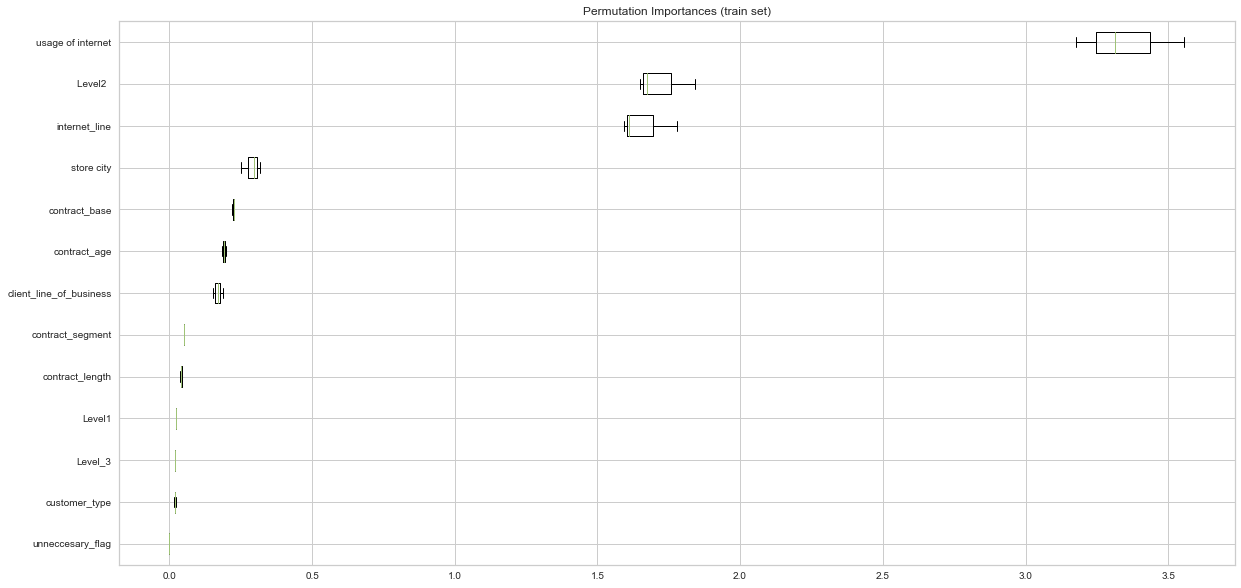

In [15]:
result = permutation_importance(best_model, X_train, y_train, n_repeats=3,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
 
fig, ax = plt.subplots(figsize=[20,10])
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
plt.show()

## SHAP

In [16]:
shap.initjs()

In [17]:
# explainer = shap.TreeExplainer(best_model)
explainer = shap.Explainer(best_model)

# Calculate Shap values
shap_values = explainer(X_train)

In [18]:
# visualize the first prediction's explanation with a force plot
# shap.plots.force(shap_values[rand_pos_index])

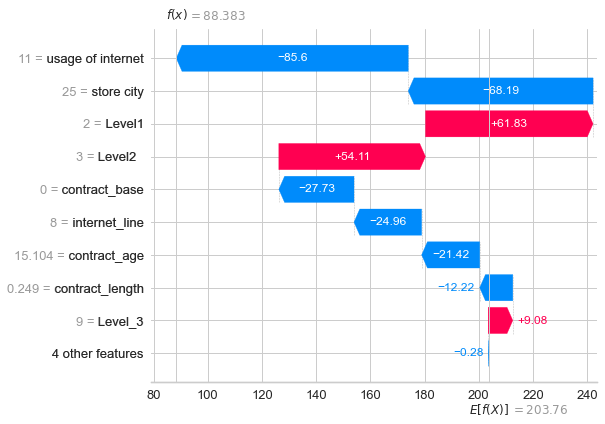

In [19]:
shap.plots.waterfall(shap_values[np.random.choice(X_train.index,1)[0]])

In [20]:
X_train.columns

Index(['store city', 'Level1', 'contract_age', 'client_line_of_business',
       'internet_line', 'customer_type', 'unneccesary_flag',
       'usage of internet', 'contract_segment', 'Level2  ', 'Level_3',
       'contract_base', 'contract_length'],
      dtype='object')

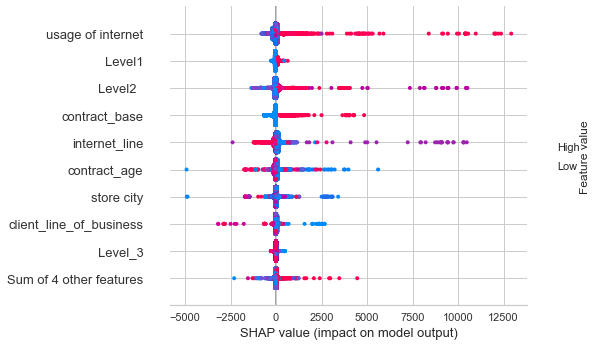

In [21]:
# shap.summary_plot(shap_values, X_test, class_names=[0,1])
# shap.summary_plot(shap_values)
shap.plots.beeswarm(shap_values)

In [22]:
df.contract_value.mean()

208.73569563373496

TODO **add values for predictors **

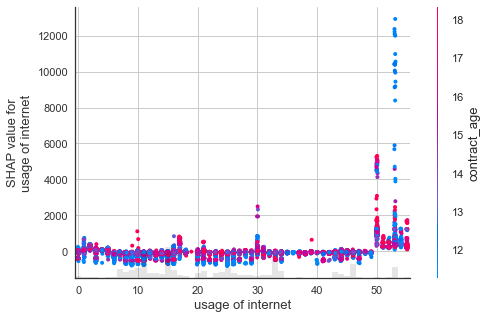

In [23]:
shap.plots.scatter(shap_values[:, 'usage of internet'], color=shap_values[:,'contract_age'])

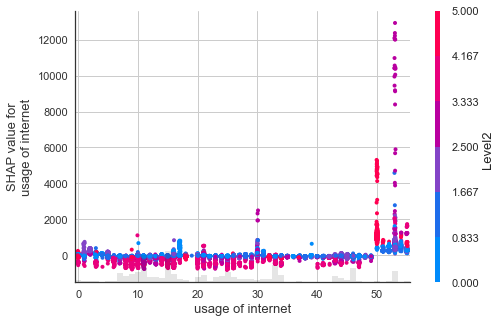

In [24]:
shap.plots.scatter(shap_values[:, 'usage of internet'], color=shap_values[:,'Level2  '])

In [25]:
feat_col = 'usage of internet'
feat2_col = 'Level2  '

print(df.iloc[X_train[((X_train[feat_col]>=48) &(X_train[feat2_col]>2))].index][feat_col].describe())
print(df.iloc[X_train[((X_train[feat_col]>=48) &(X_train[feat2_col]>2))].index][feat2_col].describe())

count                           456
unique                            6
top       Unlimited call for 3 days
freq                            267
Name: usage of internet, dtype: object
count           484
unique            3
top       Service 6
freq            292
Name: Level2  , dtype: object


In [26]:
feat_col = 'usage of internet'
feat2_col = 'Level2  '
df.iloc[X_train[((X_train[feat_col]>=48) &(X_train[feat2_col]>2))].index].contract_value.mean()

3251.4757595136984

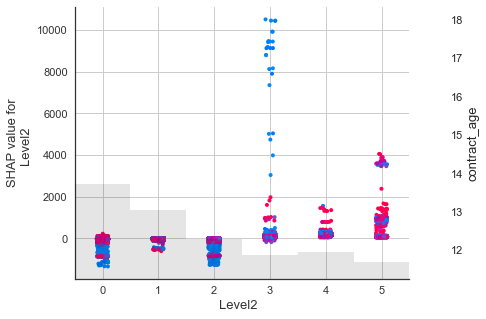

In [27]:
shap.plots.scatter(shap_values[:, 'Level2  '], color=shap_values[:,'contract_age'])

In [28]:
feat_col = 'Level2  '
feat2_col = 'contract_age'
df.iloc[X_train[((X_train[feat_col]==3) &(X_train[feat2_col]>16))].index].contract_value.mean()

273.43427776377484

In [29]:
print(df.iloc[X_train[((X_train[feat_col]==3) &(X_train[feat2_col]>12))].index][feat_col].describe())
print(df.iloc[X_train[((X_train[feat_col]==3) &(X_train[feat2_col]>12))].index][feat2_col].describe())

count          5475
unique            1
top       Service 4
freq           5475
Name: Level2  , dtype: object
count    5475.000000
mean       15.519961
std         1.812258
min        12.002740
25%        14.065753
50%        15.624658
75%        17.005479
max        18.709589
Name: contract_age, dtype: float64


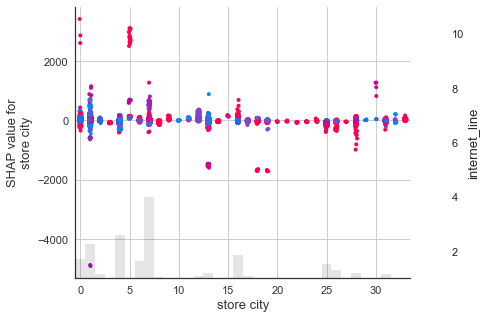

In [30]:
shap.plots.scatter(shap_values[:, 'store city'], color=shap_values[:,'internet_line'])

In [31]:
# feat_col = 'store city'
# feat2_col = 'internet_line'

# df.iloc[X_train[(X_train[feat_col].isin([27,28]))].index].contract_value.mean()

In [32]:
print(df.internet_line.unique())
df.iloc[X_train[((X_train.internet_line==6) & (X_train.contract_age<14))].index].contract_value.mean()

['Internet' 'Blend Services' 'Wifi Service' 'Hybrid' 'Unknown' 'Messaging'
 'Calling Service' 'Wifi-Internet' 'SunFibre' 'Fibre' 'Blend Internet'
 'Internet Special Service']


1871.0577884340164

In [33]:
# shap.plots.scatter(shap_values[:, 'Estimated_Income'], color=shap_values[:,'age'])

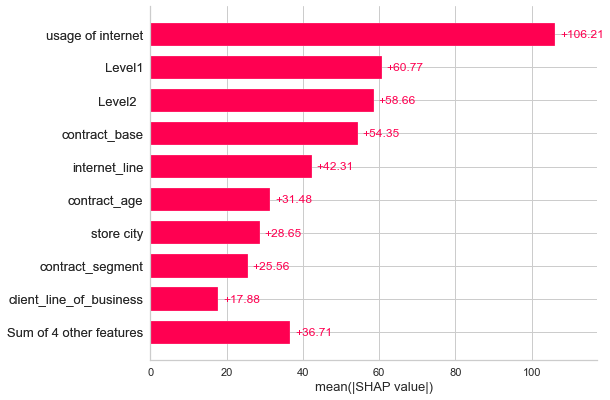

In [34]:
shap.plots.bar(shap_values)

In [35]:
# shap_obj = explainer(X_test)
# # To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. 
# # The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values 
# # to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 
# shap.plots.beeswarm(shap_obj)

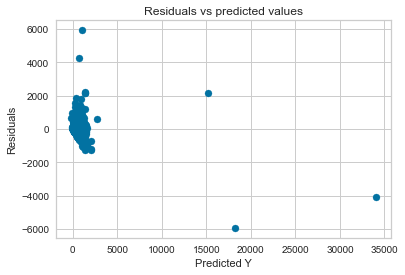

In [36]:
plot_residuals(y_test, y_pred)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_ax': <AxesSubplot:xlabel='contract_length'>})

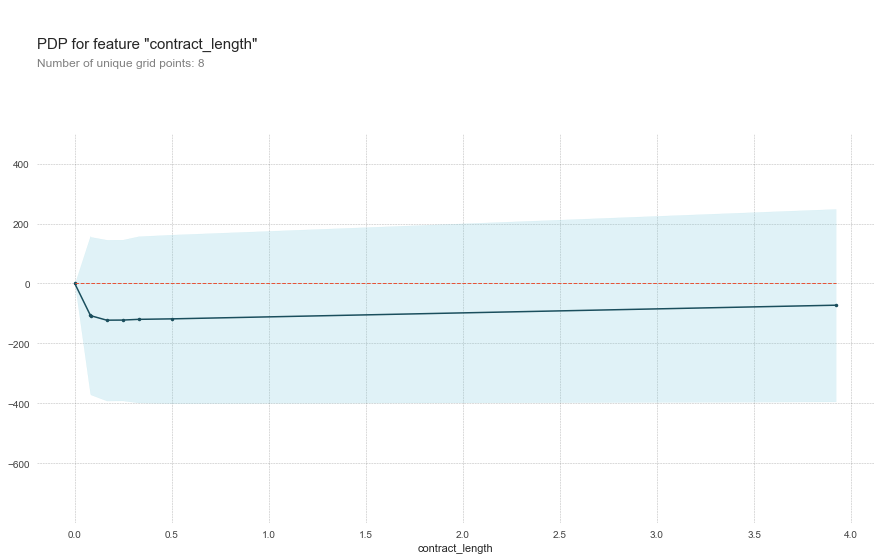

In [37]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature= 'contract_length' # chosen because of highest permutation importance
isolated = pdp_isolate(model=best_model, dataset=X_train, model_features=X_train.columns, feature=feature)

pdp_plot(isolated, feature_name=feature)

In [38]:
# indices = random.sample(range(0, X_train.shape[0]), 1000)

### Gridsearch


In [39]:
# # "colsample_by_tree" is the fraction of features (randomly selected) that will be used to train each tree.

# param_grid = { 'n_estimators': np.arange(100,201,100),
#              'max_depth': np.arange(3,13,3)}
# # 'learning_rate': ,
# # 'colsample_bytree': np.arange(0.1,0.5,0.2),

# xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

# grid_search_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, verbose=2,cv = 5, scoring = 'accuracy')

# grid_search_xgb.fit(X_train, y_train,  eval_metric = 'mlogloss')

# print('Best Score:', grid_search_xgb.best_score_)
# print('Parameters:', grid_search_xgb.best_params_)
# print('Best Model:', grid_search_xgb.best_estimator_)

In [40]:
# # you can also get the best model by:
# best_model = grid_search_xgb.best_estimator_

# grid_search_xgb.best_params_
# {'max_depth': 3, 'n_estimators': 100}

## Reference/Deprecated

In [41]:
# clf = DecisionTreeClassifier(random_state=1234)
# dt_model = clf.fit(X_train.iloc[indices], y_train.iloc[indices])
# # text_representation = tree.export_text(clf)
# # print(text_representation)  # feature names not present

In [42]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(clf, 
#                    feature_names=df_train.columns,  
#                    class_names=target_col[0],
#                    filled=True)

In [43]:
# import graphviz
# # DOT data
# dot_data = tree.export_graphviz(clf, out_file=None, 
#                                 feature_names=X_train.columns,  
#                                 class_names=target_col[0],
#                                 filled=True)

# # Draw graph
# graph = graphviz.Source(dot_data, format="png") 
# graph

In [44]:
# graph.render(filename='decision_tree.png')

In [45]:
# from IPython.display import HTML
# HTML('''<script>
# var code_show_err = false; 
# var code_toggle_err = function() {
#  var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
#  var stderr = Array.from(stderrNodes)
#  if (code_show_err){
#      stderr.forEach(ele => ele.style.display = 'block');
#  } else {
#      stderr.forEach(ele => ele.style.display = 'none');
#  }
#  code_show_err = !code_show_err
# } 
# document.addEventListener('DOMContentLoaded', code_toggle_err);
# </script>
# To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')